In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import MinMaxScaler

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [2]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [3]:
presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
    scaler = MinMaxScaler()
    llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,fear_analysts,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.000000,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.313183,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000


In [4]:
# Define emotion categories
positive_emotions = [
    'admiration', 'approval', 'caring', 'desire', 'excitement', 
    'joy', 'optimism', 'pride', 'relief'
]

negative_emotions = [
    'annoyance', 'disappointment', 'disapproval', 
    'embarrassment', 'nervousness', 'sadness', 'remorse'
]

strong_negative_emotions = [
    'anger', 'fear'
]

neutral_cognitive_emotions = [
    'confusion', 'curiosity', 'realization', 'surprise'
]

# create aggregated scores for groups
llm_output['positive_emotions'] = llm_output[positive_emotions].sum(axis=1)
llm_output['negative_emotions'] = llm_output[negative_emotions].sum(axis=1)
llm_output['strong_negative_emotions'] = llm_output[strong_negative_emotions].sum(axis=1)
llm_output['neutral_cognitive_emotions'] = llm_output[neutral_cognitive_emotions].sum(axis=1)

emotion_groups = ['positive_emotions', 'negative_emotions', 'strong_negative_emotions', 'neutral_cognitive_emotions']

llm_output['positive_emotions'] = scaler.fit_transform(llm_output[['positive_emotions']])
llm_output['negative_emotions'] = scaler.fit_transform(llm_output[['negative_emotions']])
llm_output['strong_negative_emotions'] = scaler.fit_transform(llm_output[['strong_negative_emotions']])
llm_output['neutral_cognitive_emotions'] = scaler.fit_transform(llm_output[['neutral_cognitive_emotions']])

In [5]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [28]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    #+ presentation_labels 
                    #+ qna_labels
                    #+ qna_mgmt
                    + qna_analysts
                    #+ emotions
                    + analyst_emotions
                    #+ emotion_groups
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     48.87
Date:                Wed, 23 Oct 2024   Prob (F-statistic):          4.21e-234
Time:                        13:29:09   Log-Likelihood:                -4366.2
No. Observations:                1075   AIC:                             8834.
Df Residuals:                    1024   BIC:                             9088.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

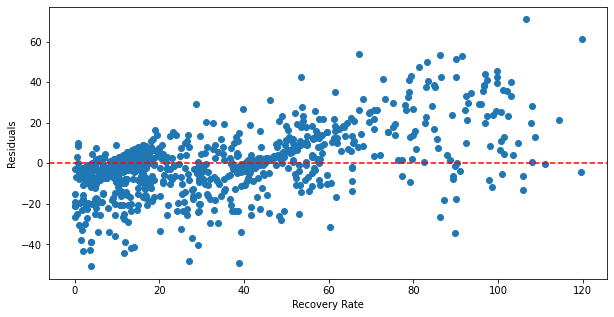

In [29]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [30]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3651.395655
17                                Financials    17.648309
11                      ActIndustryDistress1     9.086296
2                    NASDAQ 100 Index return     8.326811
4         30 year conventional mortgage rate     8.203331
3   Manufacturers inventories to sales ratio     7.317990
38                      disapproval_analysts     6.263736
18                                    Energy     5.774277
12                      ActIndustryDistress2     5.574043
1                 CBOE DJIA Volatility Index     5.555938
6                     Consumer Discretionary     5.373444
5                     Communication Services     4.880444
28                      analyst_satisfaction     3.975219
31                        annoyance_analysts     3.903060
27                          analyst_concerns     3.684507
48                          remorse_analysts     3.670715
32            

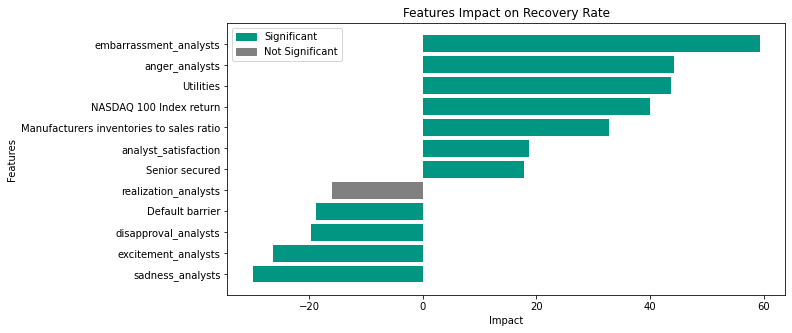

In [31]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(12)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
# Create a custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color='#009682'), plt.Rectangle((0, 0), 1, 1, color='grey')]
labels = ['Significant', 'Not Significant']

# Add the legend
plt.legend(handles, labels)
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

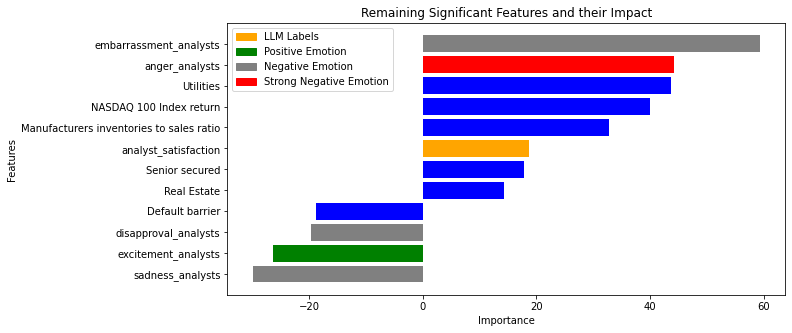

In [32]:
import matplotlib.patches as mpatches

# Filter significant features
significant_features = model.pvalues[model.pvalues < 0.05].index
importances = model.params[significant_features]  # Only significant features
importances = importances[1:]

# Sort importances by their absolute value, and select the top 10
top_12_importances = importances.abs().sort_values(ascending=False).head(12)
importances = importances[top_12_importances.index]
importances = importances.sort_values()  # Sort the values for better visualization

# Define emotion types (assuming the feature names match these emotion labels)
emotion_types = {
    'relief': 'positive',
    'remorse': 'negative',
    'nervousness': 'negative',
    'desire': 'positive',
    'fear': 'strong_negative',
    'excitement': 'positive',
    'confusion': 'negative',
    'pride': 'positive',
    'annoyance': 'negative',
    'gratitude': 'positive',
    'anger': 'strong_negative',
    'optimism': 'positive',
    'sadness': 'negative', 
    'approval': 'positive',
    'caring': 'positive',
    'disappointment': 'negative',
    'curiosity': 'positive',
    'surprise': 'positive',
    'admiration': 'positive',
    'embarrassment': 'negative',
    'realization': 'positive',
    'disapproval': 'negative',
    'joy': 'positive',
    'relief_analysts': 'positive',
    'remorse_analysts': 'negative',
    'nervousness_analysts': 'negative',
    'desire_analysts': 'positive',
    'fear_analysts': 'strong_negative',
    'excitement_analysts': 'positive',
    'confusion_analysts': 'negative',
    'pride_analysts': 'positive',
    'annoyance_analysts': 'negative',
    'gratitude_analysts': 'positive',
    'anger_analysts': 'strong_negative',
    'optimism_analysts': 'positive',
    'sadness_analysts': 'negative',
    'approval_analysts': 'positive',
    'caring_analysts': 'positive',
    'disappointment_analysts': 'negative',
    'curiosity_analysts': 'positive',
    'surprise_analysts': 'positive',
    'admiration_analysts': 'positive',
    'embarrassment_analysts': 'negative',
    'realization_analysts': 'positive',
    'disapproval_analysts': 'negative',
    'joy_analysts': 'positive'
}

# Map colors to each emotion type
color_mapping = {
    'positive': 'green',
    'strong_negative': 'red',
    'negative': 'gray',
}

# Apply the color mapping to the top 12 significant features
colors = []
for feature in importances.index:
    if feature in supporting_features_1 or feature in supporting_features_2:
        colors.append('blue')
    elif feature in presentation_labels or feature in qna_labels:
        colors.append('orange')
    elif feature in emotion_types:
        colors.append(color_mapping[emotion_types[feature]])
    else:
        colors.append('black')  # Default for unknown features

# Create a horizontal bar plot for the top 12 significant features
plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Remaining Significant Features and their Impact')

# Create a custom legend
handles = [
    #plt.Rectangle((0, 0), 1, 1, color='blue'),
    plt.Rectangle((0, 0), 1, 1, color='orange'),
    plt.Rectangle((0, 0), 1, 1, color='green'),
    plt.Rectangle((0, 0), 1, 1, color='gray'),
    plt.Rectangle((0, 0), 1, 1, color='red')
]
labels = [#'Financial Data', 
          'LLM Labels', 
          'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion']

# Add the legend
plt.legend(handles, labels)

# Show the plot
plt.show()


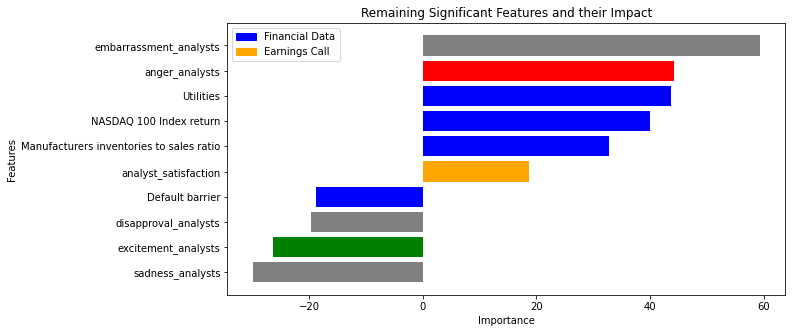

In [33]:
import matplotlib.patches as mpatches

# Filter significant features
significant_features = model.pvalues[model.pvalues < 0.05].index
importances = model.params[significant_features]  # Only significant features
importances = importances[1:]

# Sort importances by their absolute value, and select the top 10
top_12_importances = importances.abs().sort_values(ascending=False).head(10)
importances = importances[top_12_importances.index]
importances = importances.sort_values()  # Sort the values for better visualization

# Define emotion types (assuming the feature names match these emotion labels)
emotion_types = {
    'relief': 'positive',
    'remorse': 'negative',
    'nervousness': 'negative',
    'desire': 'positive',
    'fear': 'strong_negative',
    'excitement': 'positive',
    'confusion': 'negative',
    'pride': 'positive',
    'annoyance': 'negative',
    'gratitude': 'positive',
    'anger': 'strong_negative',
    'optimism': 'positive',
    'sadness': 'negative', 
    'approval': 'positive',
    'caring': 'positive',
    'disappointment': 'negative',
    'curiosity': 'positive',
    'surprise': 'positive',
    'admiration': 'positive',
    'embarrassment': 'negative',
    'realization': 'positive',
    'disapproval': 'negative',
    'joy': 'positive',
    'relief_analysts': 'positive',
    'remorse_analysts': 'negative',
    'nervousness_analysts': 'negative',
    'desire_analysts': 'positive',
    'fear_analysts': 'strong_negative',
    'excitement_analysts': 'positive',
    'confusion_analysts': 'negative',
    'pride_analysts': 'positive',
    'annoyance_analysts': 'negative',
    'gratitude_analysts': 'positive',
    'anger_analysts': 'strong_negative',
    'optimism_analysts': 'positive',
    'sadness_analysts': 'negative',
    'approval_analysts': 'positive',
    'caring_analysts': 'positive',
    'disappointment_analysts': 'negative',
    'curiosity_analysts': 'positive',
    'surprise_analysts': 'positive',
    'admiration_analysts': 'positive',
    'embarrassment_analysts': 'negative',
    'realization_analysts': 'positive',
    'disapproval_analysts': 'negative',
    'joy_analysts': 'positive'
}

# Map colors to each emotion type
color_mapping = {
    'positive': 'green',
    'strong_negative': 'red',
    'negative': 'gray',
}

# Apply the color mapping to the top 12 significant features
colors = []
for feature in importances.index:
    if feature in supporting_features_1 or feature in supporting_features_2:
        colors.append('blue')
    elif feature in presentation_labels or feature in qna_labels:
        colors.append('orange')
    elif feature in emotion_types:
        colors.append(color_mapping[emotion_types[feature]])
    else:
        colors.append('black')  # Default for unknown features

# Create a horizontal bar plot for the top 12 significant features
plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Remaining Significant Features and their Impact')

# Create a custom legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color='blue'),
    plt.Rectangle((0, 0), 1, 1, color='orange'),
]
labels = ['Financial Data', 'Earnings Call']

# Add the legend
plt.legend(handles, labels)

# Show the plot
plt.show()
